In [1]:
import ee
import pandas as pd
from datetime import datetime

In [2]:
# Initialize Earth Engine
ee.Initialize()

In [3]:
station_info_path = "/home/khanalp/code/PhD/preprocessICOSdata/csvs/01_stationinfo_L0_ICOS2025_with_heights.csv"

In [5]:
df_station_details = pd.read_csv(station_info_path)

In [ ]:
df_station_details['start_date'] = pd.to_datetime(df_station_details['start_date']).dt.strftime('%Y-%m-%d')
df_station_details['end_date'] = pd.to_datetime(df_station_details['end_date']).dt.strftime('%Y-%m-%d')

In [15]:
# Define point and time range
point = ee.Geometry.Point([29.61, 67.7549]) # lon,lat
start_date = '2017-01-01'
end_date = '2024-12-31'

In [16]:
# Select all relevant bands
collection = ee.ImageCollection('MODIS/006/MOD11A1') \
    .filterDate(start_date, end_date) \
    .filterBounds(point) \
    .select([
        'LST_Day_1km', 'Day_view_time',
        'LST_Night_1km', 'Night_view_time'
    ])

/home/khanalp/.local/lib/python3.10/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD11A1! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1

  warnings.warn(warning, category=DeprecationWarning)


In [17]:
# Process: scale LST to Celsius, view times to hours
def process(img):
    lst_day_c = img.select('LST_Day_1km').multiply(0.02).subtract(273.15).rename('LST_Day_C')
    lst_night_c = img.select('LST_Night_1km').multiply(0.02).subtract(273.15).rename('LST_Night_C')
    return img.addBands(lst_day_c).addBands(lst_night_c)

In [18]:
processed = collection.map(process)

In [19]:
# Sample at the point (MODIS scale = 1000 m)
scale = 1000
results = processed.getRegion(point, scale).getInfo()

In [20]:
# Convert to pandas DataFrame
header = results[0]
records = results[1:]
df = pd.DataFrame(records, columns=header)

In [21]:
# Convert 'time' from milliseconds since epoch to datetime and set as index
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

In [22]:
df.drop(columns=['time'], inplace=True)

In [23]:
df = df.set_index('datetime')

In [24]:
df.columns

Index(['id', 'longitude', 'latitude', 'LST_Day_1km', 'Day_view_time',
       'LST_Night_1km', 'Night_view_time', 'LST_Day_C', 'LST_Night_C'],
      dtype='object')

In [25]:
# Convert 'Day_view_time' from tenths of hours to hours
df['Day_view_time'] = df['Day_view_time'].astype(float) * 0.1
# Convert 'Day_view_time' from tenths of hours to hours
df['Night_view_time'] = df['Night_view_time'].astype(float) * 0.1

# Keep only relevant columns
df = df[['LST_Day_C', 'Day_view_time','LST_Night_C', 'Night_view_time']]

# Show the cleaned DataFrame
print(df)


            LST_Day_C  Day_view_time  LST_Night_C  Night_view_time
datetime                                                          
2017-01-01        NaN            NaN          NaN              NaN
2017-01-02        NaN            NaN          NaN              NaN
2017-01-03        NaN            NaN          NaN              NaN
2017-01-04     -27.27           11.1          NaN              NaN
2017-01-05     -27.25           11.8          NaN              NaN
...               ...            ...          ...              ...
2022-11-11        NaN            NaN        -5.01             21.3
2022-11-12        NaN            NaN          NaN              NaN
2022-11-13      -5.75           11.4        -7.17             21.0
2022-11-14        NaN            NaN          NaN              NaN
2022-11-15        NaN            NaN          NaN              NaN

[2133 rows x 4 columns]


<Axes: xlabel='datetime'>

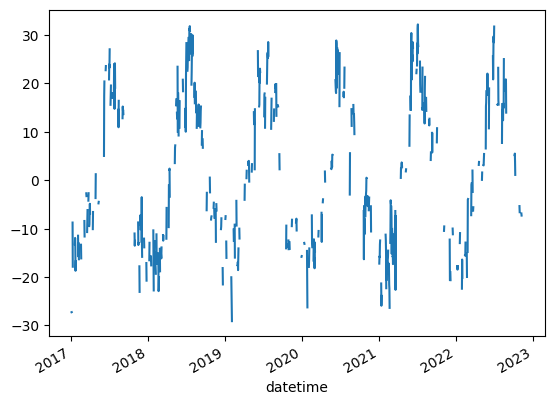

In [26]:
df.LST_Day_C.plot()

In [16]:
df.to_csv('/home/khanalp/paper01/output/LSTMODIS/IT-Ren_2022.csv', index=True)

In [17]:
# Filter df for dates between 2004-06-01 and 2004-08-31
summer_df = df.loc['2022-06-01':'2022-08-31']
print(summer_df)

Empty DataFrame
Columns: [LST_Day_C, Day_view_time, LST_Night_C, Night_view_time]
Index: []


<Axes: xlabel='datetime'>

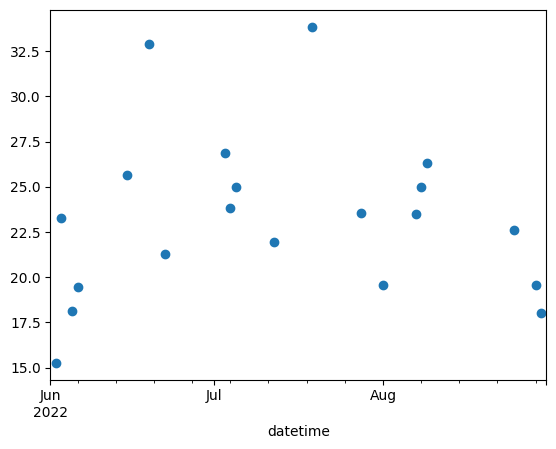

In [21]:
summer_df.LST_Day_C.plot(style='o')

<Axes: xlabel='datetime'>

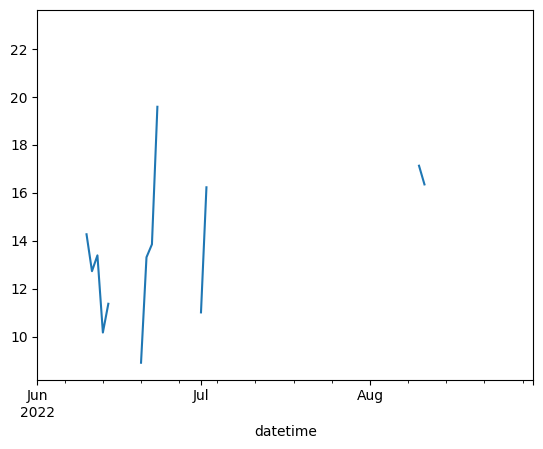

In [22]:
summer_df.LST_Night_C.plot()